# AUC as Loss: directly fitting to optimize ROC AUC

A common application of binary classification models is *ranking*, more than *classification* itself. The difference between the two is subtle:

* In classification, you want to say how likely a point is to belong to class 1 or class 0;
* In ranking, you care whether point A, who is in class 1, is more likely than another point B, in class 0, to be classified as being in the correct class.

[Learning to rank](https://en.wikipedia.org/wiki/Learning_to_rank) is a whole recent area in machine learning. Here, we focus on the binary case, which is our main concern in domains such as credit and insurance, where an individual will be compared against peers for credit or better insurance policies.



In the binary case, the [ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is a standard metric which I have previously discussed (see [here](https://takeshimg92.github.io/posts/auc-variance.html) and [here](https://takeshimg92.github.io/posts/cost_based_auc.html)). A quick review: in the supervised learning setting, where we have jointly distributed variables $(X,Y)$ (with $X$ taking values in some inner product space $\mathcal X$, and $Y$ being either 0 or 1), and a trained classifier $f: \mathcal X \to [0,1]$, the ROC AUC measures how likely $p$ is to give a higher score to a point in class 1 than to a point in class 0:

$$\mathrm{AUC} = \mathbb P(p(X) \geq p(X') | Y=1, Y'=0)$$



The model $p$ is usually parametric, $p = p_\theta$, and:
* Trained to maximize the log-likelihood $\ell(\theta)$, which usually amounts to minimizing the binary cross-entropy loss;
* Fine-tuned (via hyperparameter optimization) to maximize ROC AUC; ROC AUC is also used to compare different models and choose the winner.

I was recently wondering: **why don't we just maximize for ROC AUC from the beginning?** Since this is what we care about in the end, why optimize for another loss?

### Must-know's for today

Everything in ROC AUC analysis comes from the fact that we can write the equation above as

$$\mathrm{AUC} = \mathbf E \left[ 1_{p(X) \geq p(X')} | Y=1, Y'=0\right]\qquad (1)$$

where $1_A$ is the identity function which takes the value 1 over events in which $A$ is true and zero otherwise. Numerically, this is often approximated as the Wilcoxon-Mann-Whitney statistic: given a set of observations $\{(x_i, y_i)\}_{i=1}^n$, out of which $n_1$ are in class 1 and $n_0 = n-n_1$ are in class 0, it is given by

$$\widehat{\mathrm{AUC}} = \frac{1}{n_0 n_1} \sum_{i: y_i = 1} \sum_{j: y_j=0} 1_{p(x_i) \geq p(x_j)} \qquad (2)$$

A final point is that Eq. (2) is *expensive*: it is of order $O(n_0 n_1) = O(n^2)$. For a large, balanced dataset this can become infeasible.

I often replace the double sum for a Monte-Carlo sample: fixing a number $N \gg 1$, formally substitute

$$\frac{1}{n_0 n_1} \sum_{i: y_i=1} \sum_{j: y_j=0} \longrightarrow \frac{1}{N} \sum_{(i, j)}$$


where the sum on the right hand side samples $N$ pairs $(i, j)$ from the set $\{i: y_i=1\} \times \{j: y_j=0\}$.

### Surrogates losses

[Cortes and Mohri (2003)](https://cs.nyu.edu/~mohri/pub/auc.pdf) have discussed how the **RankBoost loss** is a **surrogate** loss for ROC AUC - i.e. it is a loss which is optimized when the ROC AUC is optimized. It is defined theoretically as

$$\mathbf E\left[\exp(-\alpha(p(X)-p(X')))|Y=1, Y'=0\right]$$

where $\alpha > 0$ is a hyperparameter which exponentially penalizes scores which are inverted between the two classes. This expression can be approximated numerically by setting up a double sum as above:

$$\frac{1}{n_0 n_1} \sum_{i: y_i = 1} \sum_{j: y_j=0} \exp(-\alpha(p(x_i)-p(x_j))).\qquad (3)$$

I've used RankBoost before by analytically computing its Jacobian and Hessian and using it as a custom loss in LightGBM - it works just fine! Notice that LightGBM only accepts *total* losses which can be written as

$$L \propto \sum_{i=1}^n \ell(x_i, y_i);$$

you can do that by writing

$$\ell(x_i, y_i) =  \sum_{j=1}^n \left[ y_i (1-y_j ) e^{-\alpha(p(x_i) - p(x_j))} + (1-y_i) y_j e^{+\alpha(p(x_i) - p(x_j))} \right]$$

# Directly optimizing the ROC AUC

I wanted to explore a bit further. Can I write a *differentiable* loss function which is the ROC AUC?

Take Eq. (1), explicitly writing the dependence on parameters $\theta$:

$$\mathrm{AUC} = \mathbf E \left[ 1_{p_\theta(X) \geq p_\theta(X')} | Y=1, Y'=0\right]$$

My goal was: **use gradient ascent to iterate** $\theta$ **in order to maximize AUC**. That requires is to solve an interesting problem: 

$$\boxed{\mbox{What is the gradient of AUC?}}$$

In what follows, we denote by the gradient operator in $\theta$ space as

$$\frac{\partial}{\partial \theta}$$

(leaving $\nabla$ for gradients in feature space, $\nabla = \partial/\partial x$).

We want to find the gradient of AUC so that we can run gradient ascend:

$$\theta_{n+1} = \theta_n + \eta \left. \frac{\partial}{\partial \theta} \mathrm{AUC}\right|_{\theta=\theta_n}$$

where $\eta$ is a learning rate.

But we have an issue here. Even if, for fixed $x$, the map $\theta \mapsto p_\theta(x)$ is smooth, it is certainly true that

$$\theta \mapsto 1_{p_\theta(x) \geq p_\theta(x')}$$

is not differentiable, and thus we cannot calculate the derivative directly.

We have two options:

* Option 1: calculate a derivative exactly, in the [distribution](https://en.wikipedia.org/wiki/Distribution_(mathematics)) sense;

* Option 2: find a smooth approximant to $1_A$ itself, which can be differentiated directly.

We show how to deal with Option 1 in the Appendix - the conclusion is that it is equivalent to Option 2 given the correct choice of regularizer. Here, we show how Option 2 can lead us to a nice computational method to calculate gradients for the ROC AUC.

First, we import the necessary libraries and create a toy dataset:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from numba import jit
from tqdm.auto import tqdm

# for hi res pictures
plt.rcParams['figure.dpi'] = 140
plt.rcParams['figure.figsize'] = [6.0, 3.0]

In [7]:
X, y = make_classification(n_samples=2000, n_informative=9, 
                           n_redundant=0, n_repeated=0, 
                           random_state=2)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.4, 
                                                    random_state=4)

Let us also train a **baseline logistic regression** model, which we will use to compare our metrics in what follows:

In [9]:
base = LogisticRegression().fit(X_train, y_train)

In [19]:
print("Train AUC: {0:.3f}".format(roc_auc_score(y_train, base.predict_proba(X_train)[:,1])))
print("Train AUC: {0:.3f}".format(roc_auc_score(y_test, base.predict_proba(X_test)[:,1])))

Train AUC: 0.899
Train AUC: 0.895


### Regularized kernel ROC AUC

Essentially, the infractor is the Heaviside function $1_{x\geq 0}$. This is a shorthand for the function

$$\begin{cases}
1 & \mbox{if} & x \geq 0\\
0 & \mbox{if} & x < 0
\end{cases}.$$

Our proposal is to substitute this function by an infinitely smooth one. Let

$$\sigma_\epsilon(x) \equiv \sigma\left(\frac{x}{\varepsilon}\right), \quad \sigma(x) = \frac{1}{1+e^{-x}}$$


be a sigmoid function with a parameter $\varepsilon$.

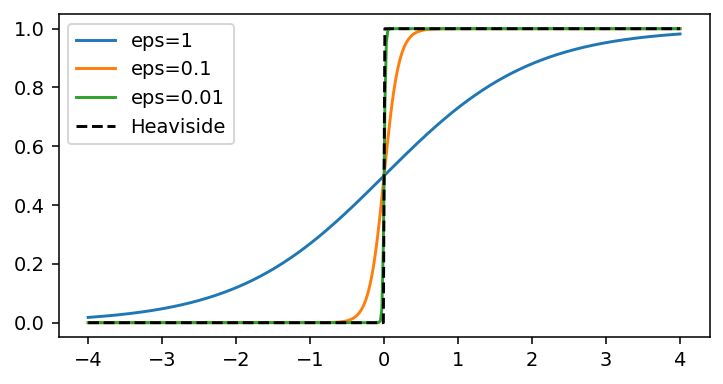

In [8]:
@jit(nopython=True)
def sigma_eps(x, eps=0.01):
    return 1.0/(1.0 + np.exp(-x/eps))

# plotting to compare with Heaviside function
x = np.linspace(-4,4, 400)
for eps in [1, 0.1, 0.01]:
    plt.plot(x, sigma_eps(x, eps), label=f'eps={eps}')
plt.plot(x, np.heaviside(x, 1), label='Heaviside', color='black', linestyle='--')
plt.legend()
plt.show()

See how $\varepsilon=0.01$ or lower already gives a fantastic approximation to the Heaviside function.

Our approach will then be to formally substitute $1_{x\geq 0}$ by $\sigma_\varepsilon(x)$. Define a **regularized kernel ROC AUC** as 

$$\mathrm{rAUC} = \mathbf E[\sigma_\varepsilon(p_\theta(X) - p_\theta(X')) | Y=1, Y'=0].\qquad (4)$$

Below, we show how this quantity approximates the actual ROC AUC, with the error becoming smaller as $\varepsilon$ decreases:

> Since the Wilcoxon-Mann-Whitney statistic is sometimes called the U-statistic, we name the function to calculate rAUC as `reg_u_statistic`:

In [20]:
def reg_u_statistic(y_true, y_probs, eps=0.01):
    p = y_probs[y_true==1]
    q = y_probs[y_true==0]
    
    aux = []
    for pp in p:
        for qq in q:
             aux.append(sigma_eps(pp-qq, eps=eps))
    
    u = np.array(aux).mean()
    return u

_ = reg_u_statistic(np.array([1,1,0]), np.array([1.0,1.0,0.0]))

In [22]:
y_probs = base.predict_proba(X_test)[:,1]

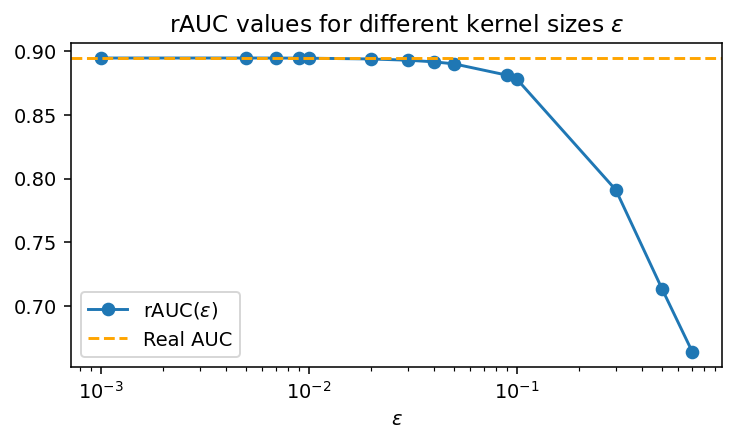

In [36]:
eps_list = sorted([0.1, 0.7, 0.5, 0.3, 0.09, 0.05, 0.04, 0.03, 0.02, 0.01, 0.009, 0.007, 0.005, 0.001])
reg_auc_list = [reg_u_statistic(y_test, y_probs, eps)  for eps in eps_list]    

plt.plot(eps_list, reg_auc_list, marker='o', label='rAUC($\epsilon$)')
plt.axhline(roc_auc_score(y_test, y_probs), linestyle='--', color='orange', label='Real AUC')
plt.xscale('log')
plt.xlabel('$\epsilon$')
plt.title("rAUC values for different kernel sizes $\epsilon$")
plt.legend()
plt.show()

See how for $\varepsilon \sim 0.01$ we essentially calculate the same thing, as expected.

### Implement gradient ascent on rAUC

For any model outputting a probabilistic output $p_\theta(x)$, we can write the gradient of the regularized AUC as

$$\frac{\partial}{\partial \theta} \mathrm{rAUC} = \mathbf E \left[ \frac{\partial}{\partial \theta} \sigma_\varepsilon(p_\theta(X) - p_\theta(X')) \left| \atop \right.  Y=1, Y'=0 \right]$$

Now we can use that the sigmoid has a simple derivative,

$$\sigma'(x) = \sigma(x)(1-\sigma(x))$$

to write this as

$$\frac{\partial}{\partial \theta} \mathrm{rAUC} = \mathbf E \left[\sigma_\varepsilon(p_\theta(X) - p_\theta(X'))[1 - \sigma_\varepsilon(p_\theta(X) - p_\theta(X'))] \frac{1}{\varepsilon} \frac{\partial}{\partial \theta} (p_\theta(X) - p_\theta(X'))  \left| \atop \right.  Y=1, Y'=0 \right]$$

To reduce clutter, call

$$\begin{align*}
\Delta p_\theta(X, X') &\equiv p_\theta(X) - p_\theta(X')\\
\Delta p'_\theta(X, X')& \equiv \frac{\partial}{\partial \theta} (p_\theta(X) - p_\theta(X'))
\end{align*}$$

whence

$$\frac{\partial}{\partial \theta} \mathrm{rAUC} = \frac{1}{\varepsilon}\mathbf E \left[\sigma_\varepsilon(\Delta p_\theta(X, X'))[1 - \sigma_\varepsilon(\Delta p_\theta(X, X'))] \Delta p'_\theta(X, X') \left| \atop \right.  Y=1, Y'=0 \right]\qquad (5)$$

Now, let us approximate $\mathbf E[\cdot]$ by an average over pairs $(i,j)$. We will use a Monte-Carlo approximation - our experience shows it is *much* faster than iterating over the whole set of pairs - so

$$\boxed{\frac{\partial}{\partial \theta} \widehat{\mathrm{rAUC}}= \frac{1}{\varepsilon N} \sum_{(i,j)} \sigma_\varepsilon(\Delta p_\theta(x_i, x_j))[1 - \sigma_\varepsilon(\Delta p_\theta(x_i, x_j))] \Delta p'_\theta(x_i, x_j) }$$

and the gradient ascent equation becomes

$$\theta_{n+1} = \theta_n + \eta \left.\frac{\partial}{\partial \theta} \widehat{\mathrm{rAUC}} \right|_{\theta=\theta_n}$$

$$\boxed{\theta_{n+1} = \theta_n + \frac{\eta}{\varepsilon N} \sum_{(i,j)} \sigma_\varepsilon(\Delta p_{\theta_n}(x_i, x_j))[1 - \sigma_\varepsilon(\Delta p_{\theta_n}(x_i, x_j))] \Delta p'_{\theta_n}(x_i, x_j)}$$

Notice that, since we are using $N$ samples to calculate the gradient, this is a **stochastic gradient ascent** algorithm.

**Logistic regression case**: in a logistic regression where

$$p_\theta(x) = \frac{1}{1 + e^{-\theta_0 - \theta \cdot x}}$$

we see that 

$$p_\theta(x) \geq p_\theta(x') \iff \theta \cdot x \leq \theta \cdot x'$$

All that matters, then, is that $\theta \cdot (x'-x) \geq 0$; formally we may substitute the $\Delta p_\theta$ terms above (and get a minus sign outside from the derivative) by this, to obtain 

$$\boxed{\theta_{n+1} = \theta_n - \frac{\eta}{\varepsilon N } \sum_{(i,j)} \sigma_\varepsilon(\theta_n \cdot (x_j-x_i))[1 - \sigma_\varepsilon(\theta_n \cdot (x_j-x_i))] (x_j - x_i) } \quad \mbox{(logistic regression)}$$

> *Important*: since only the *difference* between scores matters, the $\theta_0$ bias term is *indefinite* - it cannot be determined by this procedure alone. This makes sense - it does not contribute to the overall difference between scores, only to absolute score values, and would indeed be penalized in absolute losses such as cross entropy.

### Stochastic Gradient Ascent: numerical calculation

First, we separate both classes:

In [24]:
X1 = X_train[y_train==1]
X0 = X_train[y_train==0]

In [30]:
@jit(nopython=True)
def stochastic_gradient(theta, X1, X0, N=1000, eps=0.01, random_state=1):

    np.random.seed(random_state)
    
    indices_1 = np.random.choice(np.arange(X1.shape[0]), size=N)
    indices_0 = np.random.choice(np.arange(X0.shape[0]), size=N)
    
    X1_, X0_ = X1[indices_1], X0[indices_0]
    
    avg = np.zeros_like(theta)    
    for xi, xj in zip(X1_, X0_):
        dx = xj - xi
        sig = sigma_eps(theta @ dx, eps=eps)
        avg = avg + sig * (1-sig) *dx

    return avg / (N * eps)

Our hyperparameters:
* 900 epochs;
* An initial learning rate of $\eta_0 = 0.5$;
* A learning rate scheduler
  
  $$\eta_{n+1} = \frac{\eta_n}{1+\gamma}$$

  for $\gamma = 10^{-4}$ as a discount factor.

In [27]:
epochs = 900
lr = 0.5
n_mc = 500

gamma = 0.0001

np.random.seed(123)

Randomly initialize $\theta$:

In [28]:
theta = np.random.randn(X_train[0].shape[0])

In [31]:
aucs_list = []
test_aucs_list = []
epochs_list = list(range(epochs))
for seed, epoch in enumerate(tqdm(epochs_list)):
    
    # learning rate scheduler
    lr = lr / (1+gamma)
    
    theta = theta - lr * stochastic_gradient(theta, X1, X0, N=n_mc, random_state=seed)
    aucs_list.append(roc_auc_score(y_train, theta @ X_train.T))
    test_aucs_list.append(roc_auc_score(y_test, theta @ X_test.T))

  0%|          | 0/900 [00:00<?, ?it/s]

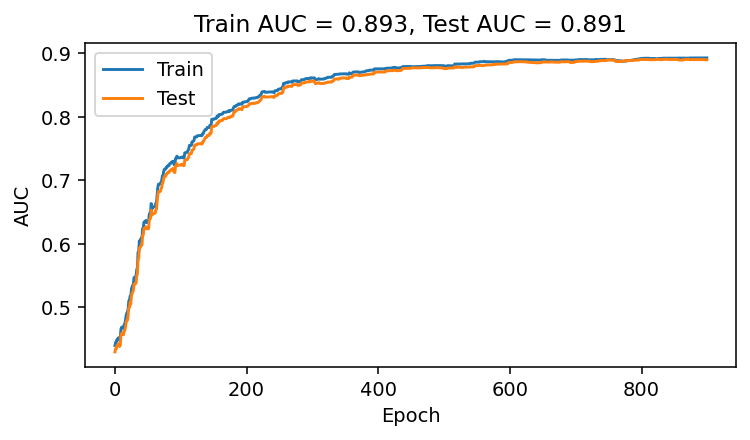

In [37]:
plt.plot(epochs_list, aucs_list, label='Train')
plt.plot(epochs_list, test_aucs_list, label='Test')
plt.title(f'Train AUC = {round(np.max(aucs_list),3)}, Test AUC = {round(np.max(test_aucs_list),3)}')
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.show()

It works! We have explicitly trained a logistic regression model to maximize ROC AUC.

## Conclusion

It is definitely possible to explicitly use ROC AUC as a loss function - albeit slightly regularized. For this toy example here, the approach didn't give a result too different from the one obtained by simply minimizing cross-entropy; however, it would be interesting to see:
* How we can go beyond logistic regression - dense neural networks seem like a natural candidate, although it would be nice to somehow implement this on tree-based models;
* In what cases it would provide very different results from other losses (surrogate or not);
* Since we use stochastic gradients, any other method such as Adam or RMSProp should be usable instead - it would be interesting to check how that changes our training results.

## Appendix

(This section assumes familiarity with the theory of [distributions](https://en.wikipedia.org/wiki/Distribution_(mathematics)))

The Heaviside function $x \mapsto 1_{x\geq 0}$ can be interpreted as a distribution; physicists are used to this interpretation, where Dirac delta functions pop up from the derivatives of discontinuous functions. 

We can then, in the sense of distributions, differentiate it.

Explicitly: assume we want to differentiate the function $g: \mathbf R^n \to \mathbf R$ given by

$$g(x) = 1_{f(x) \geq 0}$$

where $f$ is a $C^\infty$ function. Let $\Omega = \{x: f(x) \geq 0\}$, so we can equivalently write $g$ as $1_\Omega$. Further let $\varphi$ be a test function. By definition of the derivative of a distribution,

$$\langle \nabla 1_\Omega, \varphi\rangle = - \langle  1_\Omega, \nabla\varphi\rangle = - \int_\Omega \nabla \varphi \, dV$$

where $dV$ is the volume element in $\mathbf R^n$.

Now, Gauss's theorem for gradients yields

$$\int_\Omega \nabla \varphi \, dV = \oint_{\partial \Omega} \varphi \hat n \, dS$$

where $\hat n$ is the outward normal vector to the boundary of $\Omega$. Hence,

$$\langle \nabla 1_\Omega, \varphi\rangle = - \oint_{\partial \Omega} \varphi \hat n\; dS = \langle -\hat n \;\mathrm{d}\Sigma, \varphi \rangle$$

with $\mathrm{d}\Sigma$ being the area form on $\partial \Omega$: it is the distribution that, integrated over the whole surface, yields its area. It is given by

$$\langle \mathrm{d}\Sigma, \varphi \rangle = \int_{\partial \Omega} \varphi \; dS.$$



Hence, we have

$$\nabla 1_\Omega = - \hat n \,\mathrm{d}\Sigma.$$

We can develop it further. The boundary $\partial \Omega$ is the locus of $f(x) = 0$; one can show that, schematically, 

$$\mathrm{d}\Sigma = \delta(f(x))$$

where $\delta$ is the Dirac delta distribution.

> A nice example of this formula is, in spherical coordinates in $\mathbf R^3$, showing that integrating $\delta(r-R)$ yields the correct area for a sphere of radius $R$.

We conclude that

$$\boxed{\nabla 1_{f(x) \geq 0} = - \hat n \; \delta(f(x))}$$

Consider our case, where we want to calculate 

$$\frac{\partial} {\partial \theta} 1_{f(\theta)}$$

where $f(\theta) = p_\theta(X) - p_\theta(X') = \Delta p_\theta(X, X')$; we have 

$$\frac{\partial} {\partial \theta} 1_{p_\theta(X) - p_\theta(X')} = - \hat n \; \delta(\Delta p_\theta(X, X'));$$

now, $\hat n$ must be a normal vector to the surface with locus $p_\theta(X) = p_\theta(X')$; then it must be proportional to the gradient,

$$\hat n \propto \frac{\partial} {\partial \theta} \Delta p_\theta(X, X') = \Delta p_\theta'(X,X')$$

so

$$\frac{\partial} {\partial \theta} 1_{p_\theta(X) - p_\theta(X')} \propto \delta(\Delta p_\theta(X, X'))\Delta p_\theta'(X,X').\qquad (*)$$

This result is exact and final; however, it cannot be implemented directly due to the presence of the delta function. 

One can use [approximations of the identity](https://en.wikipedia.org/wiki/Dirac_delta_function#Representations_of_the_delta_function:~:text=Dirac%20delta%20function-,Representations%20of%20the%20delta%20function,-Approximations%20to%20the) to approximate the delta function: 

Let $\eta(x)$ be a real function which integrates to 1. Then, the family of functions 

$$\eta_\varepsilon(x) = \frac{1}{\varepsilon} \eta \left( \frac{x}{\varepsilon}\right)$$

converges in the distribution sense to delta as $\varepsilon$ goes to 0.

If we choose

$$\eta(x) = \sigma(x)(1-\sigma(x)) = \frac{d}{dx} \sigma(x)$$

with $\sigma(x)$ being the standard sigmoid function, then we see that

$$\eta_\varepsilon(x) = \frac{1}{\varepsilon} \sigma_\varepsilon(x) (1 - \sigma_\varepsilon(x))$$

approximates the delta function - plugging it back in $(*)$ we get

$$\frac{\partial} {\partial \theta} 1_{p_\theta(X) - p_\theta(X')} \approx \frac{1}{\varepsilon} \sigma_\varepsilon(\Delta p_\theta(X, X')) (1 - \sigma_\varepsilon(\Delta p_\theta(X, X')))\Delta p_\theta'(X, X')$$

which is exactly what we have in Eq. (5). Hence, our two approaches are equivalent.